In [1]:
!git clone -b master  https://github.com/neuraloperator/neuraloperator.git

Cloning into 'neuraloperator'...
remote: Enumerating objects: 8320, done.
remote: Counting objects: 100% (2216/2216), done.
remote: Compressing objects: 100% (820/820), done.
remote: Total 8320 (delta 1433), reused 2097 (delta 1370), pack-reused 6104
Receiving objects: 100% (8320/8320), 77.93 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (5419/5419), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Copy of Darcy_241.zip" -d "/content/drive/My Drive/darcy flow"

Archive:  /content/drive/MyDrive/Copy of Darcy_241.zip
replace /content/drive/My Drive/darcy flow/piececonst_r241_N1024_smooth2.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!pip install h5py


In [8]:
import h5py

# Open the file
with h5py.File('/content/drive/MyDrive/NavierStokes/ns_V1e-3_N5000_T50.mat', 'r') as file:
    # Print the keys in the file
    print(list(file.keys()))
    u_dataset = file['u']

    # Print the shape of the dataset
    print(u_dataset.shape)


['a', 't', 'u']
(50, 64, 64, 5000)


In [3]:
%cd /content/neuraloperator/



/content/neuraloperator


In [19]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import torch.nn.functional as F
from timeit import default_timer
from utilities3 import *

torch.manual_seed(0)
np.random.seed(0)

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        #print('conv1d:',x.shape)
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        #print('mlp ',x.shape)
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic

        self.p = nn.Linear(13, self.width) # input channel is 3: (a(x, y), x, y)
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)
        self.encoder = autoEncoder()
        self.decoder = Decoder()
        self.fc0 = nn.Linear(4, self.width)


    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        #print(x.shape)
        x = torch.cat((x, grid), dim=-1)
        #print(x.shape)
        x = self.p(x)
        #print(x.shape)
        x = x.permute(0, 4, 1, 2, 3)
        x = F.pad(x, [0,self.padding])
        x = x.reshape(20,self.width,-1)
        x = self.encoder(x)

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        x = self.q(x)

        x = self.decoder(x)
        #print(x.shape)
        x = x.reshape(10,1,64,64,49)
        x = x[..., :-self.padding]
        #print(x.shape)
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        #print(x.shape) #[20, 40, 40, 40, 1]

        return x



    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

################################################################
# configs
################################################################
TRAIN_PATH = '/content/drive/MyDrive/NavierStokes/ns_V1e-3_N5000_T50.mat'
TEST_PATH = '/content/drive/MyDrive/NavierStokes/ns_V1e-3_N5000_T50.mat'
ntrain = 1000
ntest = 200

batch_size = 10
learning_rate = 0.001
epochs = 500
iterations = epochs*(ntrain//batch_size)


runtime = np.zeros(2, )
t1 = default_timer()

modes = 8
width = 20

sub = 1
S = 64 // sub
T_in = 10
T = 40
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
x_train = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
y_train = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

reader.load_file(TEST_PATH)
x_test = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
y_test = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

print(y_train.shape)
print(y_test.shape)
assert (S == y_train.shape[-2])
assert (T == y_train.shape[-1])

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
x_test = x_test.reshape(ntest,S,S,1,T_in).repeat([1,1,1,T,1])

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()

print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        out = out.reshape(batch_size, S, S,T)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        scheduler.step()
        train_l2 += loss.item()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape(batch_size, S, S,T)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)



RuntimeError: Can't decrement id ref count (unable to close file, errno = 107, error message = 'Transport endpoint is not connected')

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (unable to close file, errno = 107, error message = 'Transport endpoint is not connected')


torch.Size([1000, 64, 64, 40])
torch.Size([200, 64, 64, 40])
205655053
0 9.193880568998793 0.3580843324661255 0.27029103636741636
1 9.09494129199993 0.2436574809551239 0.23281579375267028
2 9.25294966399997 0.22043157160282134 0.2161891782283783
3 8.844588333999127 0.20068970835208894 0.19483465135097502
4 8.862394015999598 0.18917777621746062 0.19166993856430053
5 9.060402737000913 0.18323755025863647 0.19000774383544922
6 8.953646272999322 0.1781610096693039 0.1795652413368225
7 8.795164458000727 0.17676391756534576 0.18237235724925996
8 9.082292916998995 0.17195475471019744 0.1863647437095642
9 9.02721191800083 0.17074664747714996 0.17277234077453613
10 8.959365781000088 0.1647998945713043 0.1706682735681534
11 8.940350912000213 0.16352965235710143 0.16835076570510865
12 9.066991562998737 0.1632563705444336 0.16945123851299285
13 8.85283370199977 0.16248694038391112 0.17197365045547486
14 8.97874202499952 0.15923278224468232 0.1663711792230606
15 9.067303837000509 0.1566669014692306

In [33]:
# Iterating over the test_loader
for batch_idx, (input_data, output_data) in enumerate(test_loader):
    # Now input_data and output_data hold the input and output of the current batch
    # You can process these variables as needed

    # Example: Print shapes of input and output of the current batch
    print(f"Batch {batch_idx}:")
    print(f"Input shape: {input_data.shape}")
    print(f"Output shape: {output_data.shape}")

    # If you want to process just one batch, you can break the loop here
    # break











Batch 0:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 1:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 2:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 3:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 4:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 5:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 6:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 7:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 8:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 9:
Input shape: torch.Size([10, 64, 64, 40, 10])
Output shape: torch.Size([10, 64, 64, 40])
Batch 10:
Input shap

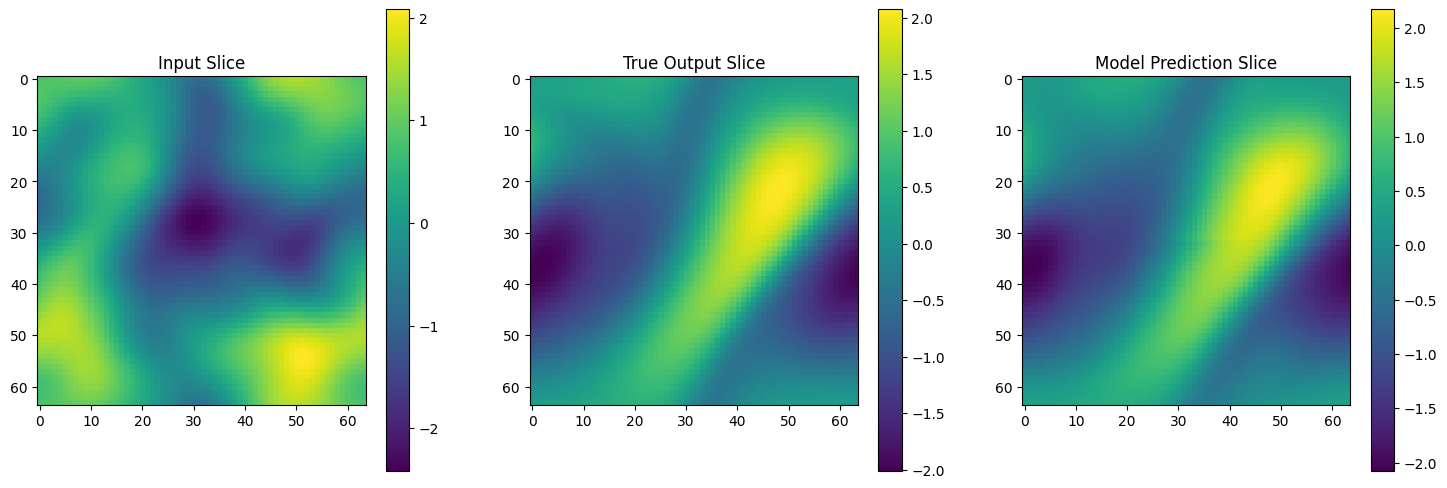

In [62]:
import matplotlib.pyplot as plt
import torch

# Set the model to evaluation mode
model.eval()
# Determine the device used by the model's parameters
device = next(model.parameters()).device

# Transfer input data and true output to the model's device
input_data, true_output = input_data.to(device), true_output.to(device)

# Rest of your code for model prediction and plotting
# ...

# Generate the model prediction
with torch.no_grad():
    model_prediction = model(input_data).reshape(batch_size, S, S, T)
    model_prediction = y_normalizer.decode(model_prediction)  # Apply normalization if required

sample_idx = 3
time_step = 35

# Convert tensors to CPU for visualization
input_slice = input_data[sample_idx, :, :, time_step, 0].cpu().numpy()
true_output_slice = true_output[sample_idx, :, :, time_step].cpu().numpy()
model_prediction_slice = model_prediction[sample_idx, :, :, time_step].cpu().numpy()


# Plotting
plt.figure(figsize=(18, 6))

# Plot input slice
plt.subplot(1, 3, 1)
plt.imshow(input_slice, cmap='viridis')
plt.colorbar()
plt.title('Input Slice')

# Plot true output slice
plt.subplot(1, 3, 2)
plt.imshow(true_output_slice, cmap='viridis')
plt.colorbar()
plt.title('True Output Slice')

# Plot model prediction slice
plt.subplot(1, 3, 3)
plt.imshow(model_prediction_slice, cmap='viridis')
plt.colorbar()
plt.title('Model Prediction Slice')

plt.show()






In [18]:
import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable

class autoEncoder(nn.Module):
    def __init__(self):
        super(autoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100352, 1024),
            #nn.Linear(256,128),
            nn.ReLU(True),
            #nn.Linear(128, 64),
            #nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3)
            )

    def forward(self, x):
        x = self.encoder(x)
        #x = self.decoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.decoder = nn.Sequential(
            nn.Linear(1024, 100352))

    def forward(self,x):
      x = self.decoder(x)
      return x



In [13]:
import math
import torch
from torch import Tensor
from typing import List, Optional
from torch.optim.optimizer import Optimizer


def adam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[int],
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    for i, param in enumerate(params):

        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sqs[i].sqrt() / math.sqrt(bias_correction2)).add_(eps)
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

        step_size = lr / bias_correction1

        param.addcdiv_(exp_avg, denom, value=-step_size)


class Adam(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    The implementation of the L2 penalty follows changes proposed in
    `Decoupled Weight Decay Regularization`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    # update the steps for each param group update
                    state['step'] += 1
                    # record the step after step update
                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'])
        return loss